### Google automl의 Efficientdet 다운로드 및 설치
* efficientdet package는 tensorflow용 구현 모듈과 tf.keras용 구현 모듈이 별도로 구성됨. 
* tf.keras용 구현 API 들이 ./automl/efficientdt/keras 디렉토리에 위치(tensorflow의 tf.keras binary가 아니라 tf.keras로 efficientdet을 구현한 API가 모여있는 디렉토리임). Colab에서 기본 설치된 keras모듈과 namespace가 충돌 되므로 keras 모듈을 삭제.  

In [1]:
!git clone --depth 1 https://github.com/google/automl

Cloning into 'automl'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 153 (delta 17), reused 45 (delta 0), pack-reused 0
Receiving objects: 100% (153/153), 11.47 MiB | 4.77 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-bkb7y6d7
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-bkb7y6d7
     |████████████████████████████████| 6.3MB 13.4MB/s 
     |████████████████████████████████| 645kB 46.2MB/s 
     |████████████████████████████████| 686kB 39.6MB/s 
     |████████████████████████████████| 122kB 58.6MB/s 
     |████████████████████████████████| 215kB 55.8MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263905 sha256=65335a66ff8467a1bc5a09152baa10b5fa2aba3d352f196bccc85499f2556576
  Stored in directory: /tmp/pip-ephem-wheel-cache-xqf_0mb5/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully un

In [5]:
!pip uninstall -y keras

In [6]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [7]:
!nvidia-smi

Mon Jun 28 19:23:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### efficientdet 수행을 위한 Library path 설정. 
* efficientdet을 setup을 하지 않고, 소스코드를 sys.path.append('/content/automl/efficientdet')로 library path 설정. 

In [8]:
import os
import sys
import tensorflow.compat.v1 as tf

In [9]:
sys.path.append('/content/automl/efficientdet')

In [10]:
# /content/automl/efficient 으로 library path가 정상적으로 잡히면 아래 모듈 import가 되어야함. 
import hparams_config
from keras import anchors
from model_inspect import ModelInspector

### COCO 데이터로 Pretrained된 efficientdet-d0 모델을 다운로드

In [11]:
MODEL = 'efficientdet-d0' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

--2021-06-28 19:23:44--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M  29.0MB/s    in 1.0s    

2021-06-28 19:23:46 (29.0 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]

Use model in /content/efficientdet-d0


In [12]:
!mkdir ./data
!wget -O ./data/img01.png https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png

--2021-06-28 19:23:47--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘./data/img01.png’

./data/img01.png    100%[===================>]   3.89M  --.-KB/s    in 0.1s    

2021-06-28 19:23:47 (32.9 MB/s) - ‘./data/img01.png’ saved [4080549/4080549]



(1080, 1920, 3)


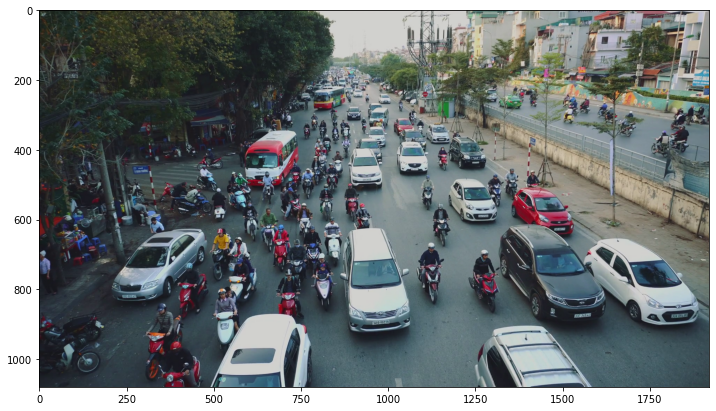

In [13]:
import cv2
import matplotlib.pyplot as plt

image_array = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)
print(image_array.shape)

plt.figure(figsize=(12, 12))
plt.imshow(image_array)

### Pretrained efficientdet 모델로 Inference 를 수행하기 위한 환경 설정
* hparams_config.Config 객체를 통해 모델 환경 설정. 

In [14]:
class INFER_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  model_dir = '/content/efficientdet-d0' # pretrained checkpoint 파일이 있는 디렉토리
  hparams = '' # csv 형식의 k=v 쌍 또는 yaml file

In [15]:
import numpy as np
from PIL import Image
import tensorflow as tf

import hparams_config
import inference
from keras import efficientdet_keras

In [16]:
#efficientdet-d0의 기본 config 확인. 
config = hparams_config.get_efficientdet_config(INFER_CFG.model_name)
print('config type:', type(config))
print(config)

config type: <class 'hparams_config.Config'>
act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_l

In [17]:
# config의 특정 항목을 update
config.is_training_bn = False
#config.image_size = '1920x1280'
config.nms_configs.score_thresh = 0.4
config.nms_configs.max_output_size = 100

config.override(INFER_CFG.hparams)

In [18]:
# P100 GPU Card에서는 아래 수행하지 말것. V100 GPU 시에는 mixed_float16으로 mixed_precision 설정. 

#policy = tf.keras.mixed_precision.Policy('mixed_float16')
#tf.keras.mixed_precision.set_global_policy(policy)
#tf.keras.mixed_precision.set_global_policy('mixed_float16')
#tf.config.run_functions_eagerly(MODEL_CONFIG.debug)

### Pretrained 모델 생성 후 Inference 수행
* config인자로 하여 EfficientDetModel생성  
* 만들어진 모델에 다운로드 된 Pretrained Weight 파일의 weight값을 model.load_weights()로 입력  

In [19]:
INFER_CFG.model_dir

'/content/efficientdet-d0'

In [20]:
import inference
from keras import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.load_weights(tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1331: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


#### checkpoint name: /content/efficientdet-d0/model
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
class_net (ClassNet)         multiple                  71274     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,927,203
Trainable params: 3,880,067
Non-trainable params: 47,136
___________________________________________________

In [21]:
from PIL import Image
import cv2

# image는 4차원 array, Tensor 모두 가능.  
imgs = [np.array(Image.open('/content/data/img01.png'))]
imgs = tf.convert_to_tensor(imgs, dtype=tf.uint8)

### 아래와 같이 numpy array도 모델에 입력되는 이미지 값으로 가능. 
''' 
img = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]
boxes, scores, classes, valid_len = model(imgs, training=False, post_mode='global')
'''
print()

In [23]:
import time

# Inference 수행하고 수행 시간을 측정. 
start_time = time.time()
boxes, scores, classes, valid_len = model(imgs, training=False, post_mode='global')
print('elapsed time:', time.time() - start_time)

elapsed time: 0.20329999923706055


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1331: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


### Inference 반환 결과 살펴보고 API로 시각화 하기
* inference model에 image tensor를 입력하여 반환된 결과는 모두 tensor이며, bounding box의 좌표, confidence score, class id 값, valid한 갯수가 반환됨. 
* config에 max_instances_per_image이 100으로 설정되었으므로 기본적으로 inference결과는 100개의 object들의 Detection 결과를 가지게 됨. 
* 이들 중 valid한 갯수(valid_len)은 이들중 의미있는 object detection 갯수를 의미함.(0 부터 valid_len-1 까지의 index를 가진 array결과가 의미있는 detection 결과임)
* inference.visualize_image()로 반화 결과를 입력하여 시각화 적용

In [24]:
boxes

<tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[ 898.7691   , 1250.5381   , 1078.944    , 1593.3597   ],
        [ 485.65506  , 1178.6895   ,  613.1528   , 1317.9205   ],
        [ 620.43     , 1313.1946   ,  905.7822   , 1625.1598   ],
        [ 870.51105  ,  490.04422  , 1078.4515   ,  778.78973  ],
        [ 505.97702  , 1356.5035   ,  636.8839   , 1533.2777   ],
        [ 628.0882   ,  211.97601  ,  842.73444  ,  485.74365  ],
        [ 648.43634  , 1553.6306   ,  911.2138   , 1901.6282   ],
        [ 875.3994   ,    3.3257673, 1039.7441   ,  182.62831  ],
        [ 925.4872   ,  301.89096  , 1075.1144   ,  460.31177  ],
        [ 619.0373   ,  873.7107   ,  927.9857   , 1069.7871   ],
        [ 351.75015  ,  582.6734   ,  511.3894   ,  738.4224   ],
        [ 690.2022   , 1238.6897   ,  860.37756  , 1316.6832   ],
        [ 677.63     , 1087.3639   ,  835.46027  , 1159.2014   ],
        [ 677.3429   , 1864.1044   ,  759.21954  , 1864.1044   ],
        [ 677.3429   , 

In [25]:
print(valid_len.numpy())
boxes.shape, scores.shape, classes.shape

[13]


(TensorShape([1, 100, 4]), TensorShape([1, 100]), TensorShape([1, 100]))

In [26]:
scores

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.84579366, 0.697856  , 0.688929  , 0.68421686, 0.67942005,
        0.64924425, 0.6139567 , 0.48414478, 0.4482823 , 0.43981293,
        0.4153153 , 0.4152773 , 0.41297245, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        

In [27]:
print('##bboxes:', boxes[0, :10], '\n##scores:', scores[0, :10], '\n##classes:', classes[0, :10])

##bboxes: tf.Tensor(
[[ 898.7691    1250.5381    1078.944     1593.3597   ]
 [ 485.65506   1178.6895     613.1528    1317.9205   ]
 [ 620.43      1313.1946     905.7822    1625.1598   ]
 [ 870.51105    490.04422   1078.4515     778.78973  ]
 [ 505.97702   1356.5035     636.8839    1533.2777   ]
 [ 628.0882     211.97601    842.73444    485.74365  ]
 [ 648.43634   1553.6306     911.2138    1901.6282   ]
 [ 875.3994       3.3257673 1039.7441     182.62831  ]
 [ 925.4872     301.89096   1075.1144     460.31177  ]
 [ 619.0373     873.7107     927.9857    1069.7871   ]], shape=(10, 4), dtype=float32) 
##scores: tf.Tensor(
[0.84579366 0.697856   0.688929   0.68421686 0.67942005 0.64924425
 0.6139567  0.48414478 0.4482823  0.43981293], shape=(10,), dtype=float32) 
##classes: tf.Tensor([3. 3. 3. 3. 3. 3. 3. 4. 4. 3.], shape=(10,), dtype=float32)


In [28]:
!mkdir -p /content/data_output

In [29]:
for i, img in enumerate(imgs):
  length = valid_len[i]
  
  img = inference.visualize_image(
      img,
      boxes[i].numpy()[:length],
      classes[i].numpy().astype(np.int)[:length],
      scores[i].numpy()[:length],
      label_map=config.label_map,
      min_score_thresh=config.nms_configs.score_thresh,
      max_boxes_to_draw=config.nms_configs.max_output_size)
  
  output_image_path = os.path.join('/content/data_output', str(i) + '.jpg')
  Image.fromarray(img).save(output_image_path)
  print('writing annotated image to %s' % output_image_path)

writing annotated image to /content/data_output/0.jpg


### Static Graph mode(Non eager mode)로 Inference 수행 성능 향상 시키기
* @tf.function을 이용하여 static mode로 inference를 수행할 수 있도록 ExportModel 클래스 생성
* inference 수행 시 ExportModel의 @tf.function이 적용된 메소드를 호출할 수 있도록 함. 

In [31]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [35]:
# p100에서 image 1920x1280일 경우 74ms, v100에서 image 512x512일 경우 24ms

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

elapsed time: 0.024749279022216797


### 시각화 함수 생성하고 inference 결과를 시각화

In [36]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [37]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

car: 0.8458
car: 0.6979
car: 0.6889
car: 0.6842
car: 0.6794
car: 0.6492
car: 0.6140
motorcycle: 0.4841
motorcycle: 0.4483
car: 0.4398
bus: 0.4153
person: 0.4153
motorcycle: 0.4130
Detection 수행시간: 0.03 초


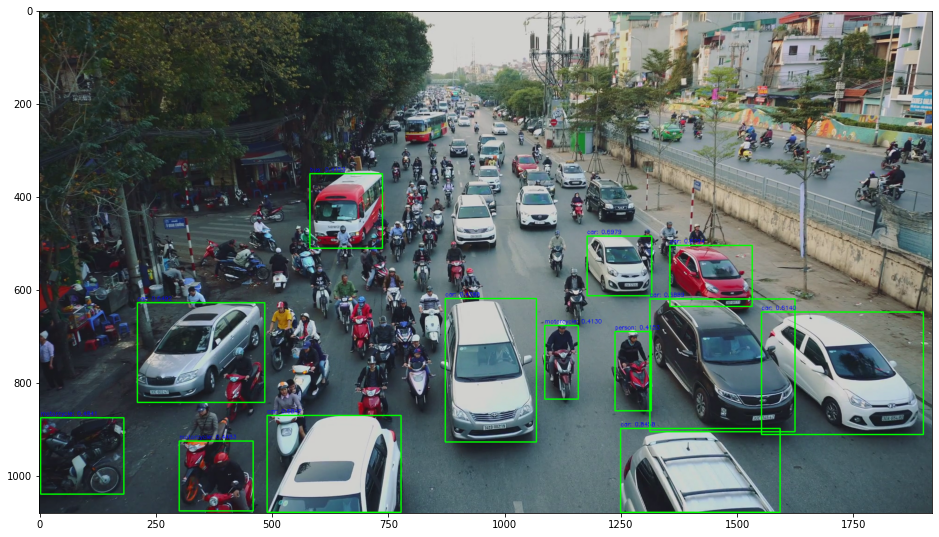

In [39]:
import cv2
img_array = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)

In [40]:
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2021-06-28 20:39:33--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.02s   

2021-06-28 20:39:33 (18.8 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]

--2021-06-28 20:39:33--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7627

(633, 806, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1331: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


person: 0.9486
person: 0.9406
person: 0.9362
person: 0.8914
car: 0.6025
car: 0.5251
Detection 수행시간: 3.83 초


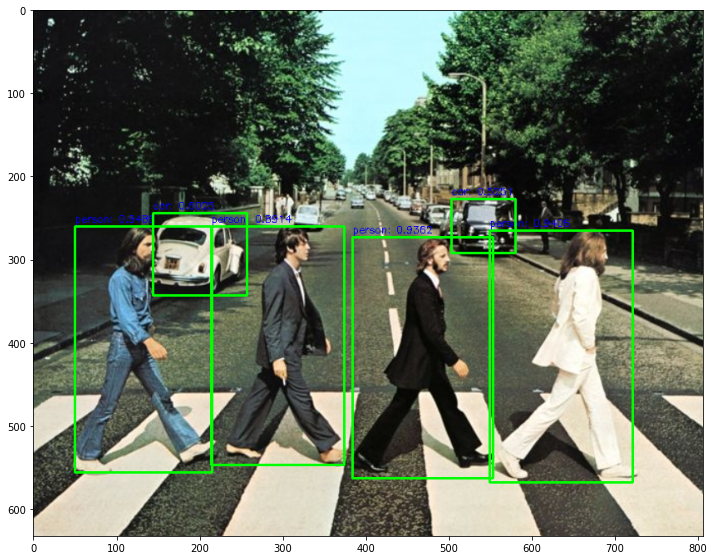

In [42]:
import cv2
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
print(img_array.shape)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### pretrained된 last checkpoint 모델의 weight를 다시 load_weight() 적용시 런타임 재시작을 적용해야 함.
* 이를 위해 앞의 로직을 아래 셀에서 모두 일괄 정리함 

In [ ]:
import os
import sys
import tensorflow.compat.v1 as tf
import numpy as np

sys.path.append('/content/automl/efficientdet')

import hparams_config
from keras import anchors
from model_inspect import ModelInspector

class INFER_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  model_dir = '/content/efficientdet-d0' # pretrained checkpoint 파일이 있는 디렉토리
  hparams = '' # csv 형식의 k=v 쌍 또는 yaml file

config = hparams_config.get_efficientdet_config(INFER_CFG.model_name)
config.is_training_bn = False
# config의 image_size를 원본 이미지 사이즈로 재 조정. config의 image_size에 가로x세로 형식으로 문자열 입력 
config.image_size = '1920x1280'
config.nms_configs.score_thresh = 0.4
config.nms_configs.max_output_size = 100
config.override(INFER_CFG.hparams)

import inference
from keras import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(INFER_CFG.model_dir))
# pretrained된 last checkpoint 모델의 weight를 다시 load_weight() 적용시 런타임 재시작을 적용해야 함. 
model.load_weights(tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.summary()

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [ ]:
# p100에서 image 1920x1280일 경우 74ms, image 512x512일 경우 27ms, v100에서 image 512x512일 경우 24ms
import time
import cv2 

img = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

In [ ]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [ ]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

In [ ]:
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)